# Population density and COVID-19 mortality
Carl Higgs, Deepti Adlakha, Jim Sallis; 9 August 2022


In [1]:
import pandas as pd

# Preliminary sampling for tertiles of population density


1. Identify the 100 largest urban centres in each region
2. Create tertiles of population density in each region
3. Randomly sample 5 cities  (or as per original suggestion, use the top 5-most dense)
4. Locate COVID-19 mortality data for these cities, where available; else, re-draw a new sample from the relevant continent-specific density tertile
5. Create a scatterplot of results

In the below the following data from the Global Human Settlements Urban Centres Database are retained:

Variable  | Description
----------|------------
GRGN_L1   | Major Geographical Region (UNDESA, 2018b), according to the classification of the main country
CTR_MN_ISO| The ISO 3 code of the main country, i.e., the country within which borders the majority of the area of the Urban Centre is located
CTR_MN_NM | The name of the main country, i.e., the country within which borders the majority of the area of the Urban Centre is located
UC_NM_MN  | The main name of the Urban Centre (the country ISO 3 is declared within ‘[]’, to support the cross border entities);
AREA      | Area in square kilometres
B15       | Total built-up area in 2015 calculated within the spatial domain of the Urban Centre of 2015, expressed in square kilometres
P15       | Total resident population in 2015

In [2]:
# Get the GHS UCDB data
# zip file including multiple formats from
# https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL/GHS_STAT_UCDB2015MT_GLOBE_R2019A/V1-2/GHS_STAT_UCDB2015MT_GLOBE_R2019A_V1_2.zip
df = pd.read_csv('./GHS/GHS_STAT_UCDB2015MT_GLOBE_R2019A_V1_2.csv')
covariates = ['GRGN_L1','CTR_MN_NM','UC_NM_MN','AREA','B15','P15']
df = df[covariates]

# only analyse named urban centres (because some small ones in Oceania in particular are not named)
# and set a minimum area of at least 10 square kilometres to mitigate extreme densities 
# for smaller, low population settlements
df = df.loc[(df['UC_NM_MN'].isna()==False) & (df['AREA']>20)]

# calculate population per sqkm in 2015
# using B15, built up area, as more closely matches values eg for Dhaka in Adlakha et al 2020 paper
# however, it is still lower (eg Dhaka approximately 28k instead of 45k)
# difference no doubt largely because targetting a time point 5 years earlier
df['population_density_2015'] = df['P15']/df['B15']
# for display purposes, make population estimate an integer
df['P15'] = df['P15'].astype('int')

df

,GRGN_L1,CTR_MN_NM,UC_NM_MN,AREA,B15,P15,population_density_2015
0,Northern America,United States,Honolulu,185,80.647377,512853,6359.210748
1,Oceania,French Polynesia,Papeete,42,14.493433,91521,6314.661586
2,Northern America,United States,Santa Maria,55,42.000805,123181,2932.831529
3,Northern America,United States,Monterey,48,27.759470,67772,2441.411486
4,Northern America,United States,Santa Barbara,60,38.101749,114753,3011.755416
...,...,...,...,...,...,...,...
13129,Oceania,New Zealand,Hillcrest,115,56.726643,219043,3861.378420
13130,Oceania,New Zealand,Tauranga,70,31.697439,84583,2668.471856
13132,Oceania,Solomon Islands,Honiara,23,4.069641,73669,18102.255748
13133,Oceania,New Caledonia,Nouméa,27,12.111768,70631,5831.666991


In [3]:
# Identify the 100 largest urban centres in each region
selected = df.groupby('GRGN_L1')\
  .apply(lambda x : x.sort_values(by = 'AREA', ascending = False)\
                    .head(100)).reset_index(drop = True)

In [4]:
# all regions have 100 records, except for Oceania, which has 6
selected.groupby('GRGN_L1')['UC_NM_MN'].count()

GRGN_L1
Africa                             100
Asia                               100
Europe                             100
Latin America and the Caribbean    100
Northern America                   100
Oceania                             40
Name: UC_NM_MN, dtype: int64

In [5]:
# Create region specific tertiles of population density for the 100 largest cities in each region which were identified
selected['region_density_tertile'] = selected.groupby(['GRGN_L1'])['population_density_2015'].transform(
                     lambda x: pd.qcut(x, 3, labels=['Q1','Q2','Q3'])
)
selected

,GRGN_L1,CTR_MN_NM,UC_NM_MN,AREA,B15,P15,population_density_2015,region_density_tertile
0,Africa,South Africa,Johannesburg,1638,900.362427,6516134,7237.234741,Q1
1,Africa,Egypt,Cairo,1585,637.769348,19734085,30942.355237,Q3
2,Africa,Nigeria,Lagos,1196,813.717163,11575042,14224.896629,Q2
3,Africa,Ghana,Accra,846,494.896210,4412617,8916.248266,Q1
4,Africa,Nigeria,Onitsha,781,261.669800,3150801,12041.136163,Q1
...,...,...,...,...,...,...,...,...
535,Oceania,Australia,River Glen Village,32,16.558352,56992,3441.911782,Q2
536,Oceania,Australia,Lindum,28,16.999882,53260,3132.995184,Q2
537,Oceania,New Caledonia,Nouméa,27,12.111768,70631,5831.666991,Q3
538,Oceania,New Zealand,Palmerston North,25,14.775366,51492,3485.018617,Q3


In [6]:
# Sample 5 cities from each region specific tertile
#sdf = df.groupby(['GRGN_L1','region_density_tertile']).sample(3,random_state=20220809)

# Top 3
# NOTE: this approach excludes cities on islands in Oceania other than Australia and NZ
# the benefit of this is some smaller cities like Madang and Kokopo in PNG have ridiculously high density estimates
# approaching 60,000 persons per sqkm.
sample = selected.groupby(['GRGN_L1','region_density_tertile']).head(3).sort_values(['GRGN_L1','region_density_tertile'])
sample

,GRGN_L1,CTR_MN_NM,UC_NM_MN,AREA,B15,P15,population_density_2015,region_density_tertile
0,Africa,South Africa,Johannesburg,1638,900.362427,6516134,7237.234741,Q1
3,Africa,Ghana,Accra,846,494.896210,4412617,8916.248266,Q1
4,Africa,Nigeria,Onitsha,781,261.669800,3150801,12041.136163,Q1
2,Africa,Nigeria,Lagos,1196,813.717163,11575042,14224.896629,Q2
5,Africa,Angola,Luanda,771,463.673126,6786991,14637.447828,Q2
6,Africa,Sudan,Khartoum,750,264.521667,5824720,22019.825176,Q2
1,Africa,Egypt,Cairo,1585,637.769348,19734085,30942.355237,Q3
13,Africa,Nigeria,Amaigbo,510,61.440853,1713470,27888.133139,Q3
23,Africa,Morocco,Casablanca,393,157.085449,3985659,25372.557616,Q3
101,Asia,Japan,Tokyo,5318,3664.912354,33028731,9012.147641,Q1


The above is a test run of the discussed sampling method.  There are some awkward aspects, in particular setting a minimum area.  The selection of top 3 vs random 3 cities within regional density tertiles is important --- top3 more or less excludes cities on small islands of Oceania (although linkage with Covid data for these could be problematic, so could be useful). 

Notwithstanding the above -- it is a selection of cities which may now be linked with Covid mortality data, and potentially custom updating of the density statistics.

Once we have Covid mortality data linked, the below are example sketches of how the scatterplots could be produced (noting the current Y axis of 'AREA' makes no sense -- just a placeholder).

In [7]:
# see the assumptions above with GHS data export, this may not be what you're after either
sample.to_csv('GHS - sampled_city_population_density_tertiles_by_region.csv', encoding='utf-8')

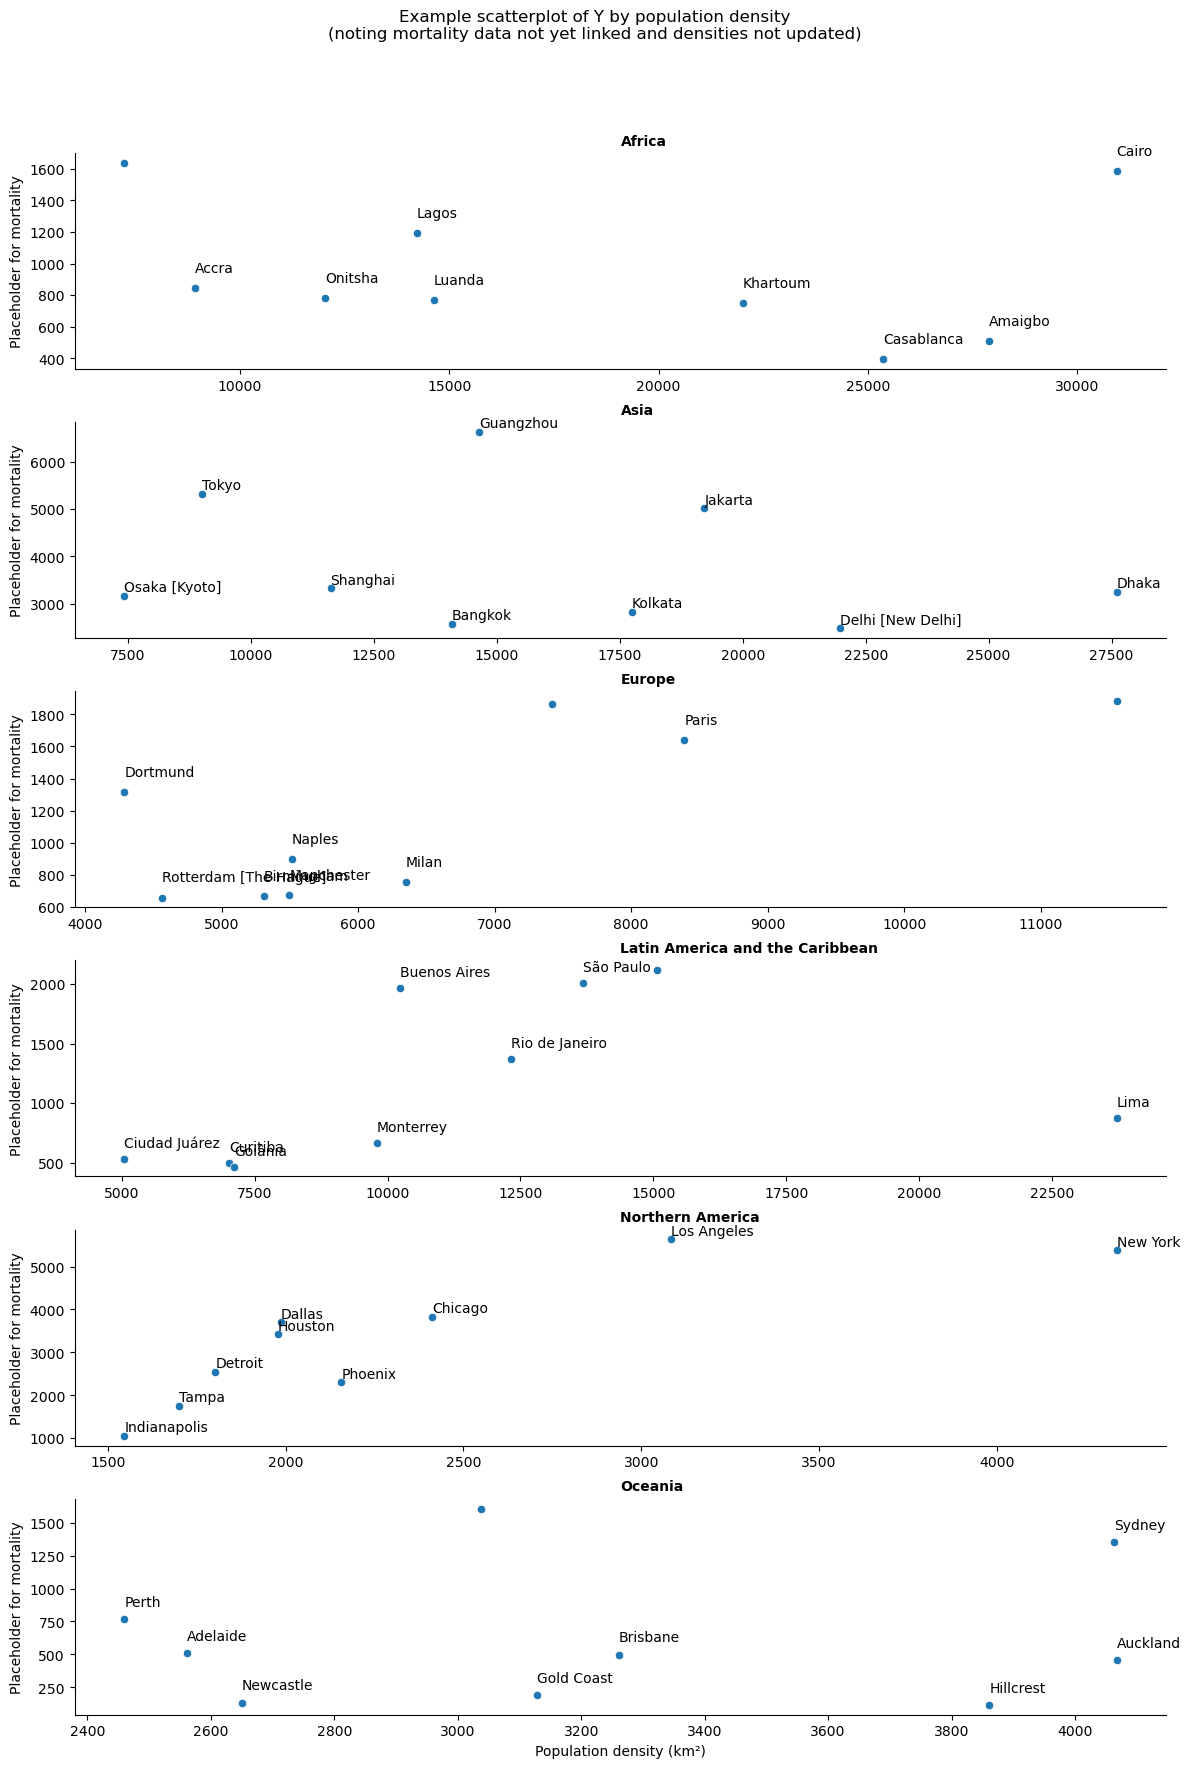

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# set up for plotting
plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
def annotate_points(x,y,t,offset=100,df=None, **kwargs):
    ax = plt.gca()
    if df is None:
        data = kwargs.pop('data')
    else:
        data=df.copy()
    for i,row in data.iterrows():
        ax.annotate(row[t], xy=(row[x],row[y]+offset))

markers=['x','o','^']
        
# scatter plot of y with regard to x by col with levels of hue
g = sns.FacetGrid(sample, col='GRGN_L1',col_wrap=1,aspect=4,
                  #hue='region_density_tertile', 
                  sharex=False,
                 sharey=False)
g.map(sns.scatterplot,'population_density_2015','AREA')
#g = sns.lmplot(x="population_density_2015", 
#               y="AREA", 
#               #hue="region_density_tertile", 
#               col="GRGN_L1",
#               data=sdf, 
#               height=3, 
#               aspect=2,
#               col_wrap=1, 
#               sharex=False,
#               sharey=False,
#               legend=True, 
#               #markers=markers,
#               fit_reg=False)

g.map_dataframe(annotate_points,'population_density_2015','AREA','UC_NM_MN')
g.set_titles('{col_name}',fontdict= { 'fontsize': 24, 'fontweight':'bold', 'horizontalalignment':'left'})
g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
g.fig.suptitle('Example scatterplot of Y by population density\n(noting mortality data not yet linked and densities not updated)')
g.set_axis_labels("Population density (km²)", "Placeholder for mortality")


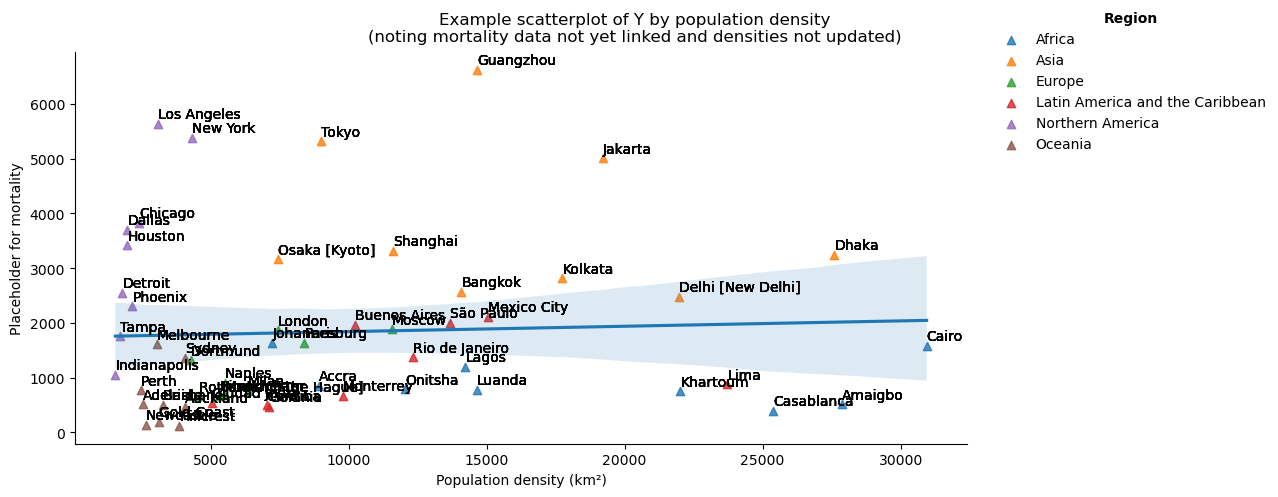

In [9]:
markers=['^']*6
g = sns.lmplot(x="population_density_2015", 
               y="AREA", 
               hue="GRGN_L1",
               data=sample, 
               aspect=2,
               legend=True, 
               fit_reg=False,
               logx=True,
               ci=95,
              truncate=True,
              markers=markers)
sns.regplot(x="population_density_2015", 
            y="AREA", 
            data=sample, 
            scatter=False, 
            ax=g.axes[0, 0])
g.map_dataframe(annotate_points,'population_density_2015','AREA','UC_NM_MN',df=sample.copy())
g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
g.fig.suptitle('Example scatterplot of Y by population density\n(noting mortality data not yet linked and densities not updated)')
g.set_axis_labels("Population density (km²)", "Placeholder for mortality")
g.legend.set_title('Region',prop={'weight':'bold'})
sns.move_legend(g, "upper right")

## not implemented attempt at changing x axis scale
#ticks = [1000,2000,4000,8000,16000]
#g.ax.set_xticks(ticks)
#plt.xscale('log')
#g.ax.set_xticklabels(ticks)
